In [70]:
from datasets import load_dataset

dataset = load_dataset("hate_speech18")

Using custom data configuration default
Found cached dataset hate_speech18 (/Users/eciel/.cache/huggingface/datasets/hate_speech18/default/0.0.0/8033f254483a20d1d10b0f1b56ded1f54326b1617872c537f354a721a6951d47)


  0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})

In [72]:
X = []
y = []
for i in dataset["train"]:
    if i["label"]!= 0 and i["label"]!= 1:
        continue
    X.append(i["text"])
    y.append(i["label"])

In [73]:
from sklearn import model_selection

In [50]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

In [51]:
import numpy as np
np.save("X_train_text.npy", X_train)
np.save("y_train_text.npy", y_train)
np.save("X_test_text.npy", X_test)
np.save("y_test_text.npy", y_test)

In [52]:
import spacy 
nlp = spacy.load('en_core_web_md')

/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_md' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [85]:
from tqdm import tqdm
X, y = {}, {}
X["train"] = np.array([nlp(example).vector for example in tqdm(X_train)])
y["train"] = np.array([example for example in y_train])


 20%|████████████████▋                                                                   | 1920/9632 [00:13<00:55, 138.77it/s]


 41%|██████████████████████████████████                                                  | 3905/9632 [00:27<00:36, 158.64it/s]


 63%|████████████████████████████████████████████████████▋                               | 6044/9632 [00:40<00:22, 156.44it/s]


 84%|██████████████████████████████████████████████████████████████████████▉             | 8128/9632 [00:54<00:10, 140.69it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 9632/9632 [01:04<00:00, 148.95it/s]


In [86]:
X["dev"] = np.array([nlp(example).vector for example in tqdm(X_test)])
y["dev"] = np.array([example for example in y_test])


100%|████████████████████████████████████████████████████████████████████████████████████| 1071/1071 [00:07<00:00, 135.75it/s]


In [78]:
np.save("X_train.npy", X["train"])
np.save("y_train.npy", y["train"])
np.save("X_dev.npy", X["dev"])
np.save("y_dev.npy", y["dev"])

KeyError: 'train'

In [10]:
import numpy as np
X = {}
y = {}
X["train"] = np.load("X_train.npy")
y["train"] = np.load("y_train.npy")
X["dev"] = np.load("X_dev.npy")
y["dev"] = np.load("y_dev.npy")

In [28]:
from sklearn.linear_model import LogisticRegression
l2 = 10
model = LogisticRegression(penalty='l2', C=1/l2)
model.fit(X["train"], y["train"])
pred = np.reshape(model.predict_proba(X["dev"])[:, 1], (model.predict_proba(X["dev"])[:, 1].shape[0], 1))
model.score(X["dev"], y["dev"])

0.8860877684407096

In [29]:
import sklearn.metrics as mc
print(mc.classification_report(np.reshape(y["dev"], (1071, 1)), np.round(pred)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       953
           1       0.17      0.01      0.02       118

    accuracy                           0.89      1071
   macro avg       0.53      0.50      0.48      1071
weighted avg       0.81      0.89      0.84      1071



In [60]:
# change threshold
threshold = 0.25
decisions = (pred >= threshold).astype(int)
print(decisions.shape)
print(mc.classification_report(np.reshape(y["dev"], (1071, 1)), decisions))

(1071, 1)
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       953
           1       0.41      0.38      0.40       118

    accuracy                           0.87      1071
   macro avg       0.67      0.66      0.66      1071
weighted avg       0.87      0.87      0.87      1071



In [69]:
mc.accuracy_score(np.reshape(y["dev"], (1071, 1)), decisions)

0.8720821661998133

In [61]:
fpr, tpr, thresholds = mc.roc_curve(y["dev"], decisions)

mc.f1_score(np.reshape(y["dev"], (1071, 1)), decisions), mc.auc(fpr, tpr)

(0.3964757709251101, 0.6570997919149163)

In [62]:
import sklearn.metrics as mc
mc.f1_score(np.reshape(y["dev"], (1071, 1)), np.round(pred))

0.016129032258064516

In [65]:
np.sum(y["dev"]) / 1071, np.sum(y["train"]) / 9632

(0.11017740429505135, 0.1119186046511628)

In [64]:
fpr, tpr, thresholds = mc.roc_curve(y["dev"], pred)
mc.auc(fpr, tpr)

0.8137994202073737

In [70]:
fpr, tpr, thresholds = mc.roc_curve(y["dev"], decisions)
mc.auc(fpr, tpr)

0.6570997919149163

In [66]:
w = np.concatenate((model.coef_, model.intercept_[None, :]), axis=1)
F_train = np.concatenate([X["train"], np.ones((X["train"].shape[0], 1))], axis=1) # Concatenating one to calculate the gradient with respect to intercept
F_dev = np.concatenate([X["dev"], np.ones((X["dev"].shape[0], 1))], axis=1)

error_train = model.predict_proba(X["train"])[:, 1] - y["train"]
error_dev = model.predict_proba(X["dev"])[:, 1] - y["dev"]

gradient_train = F_train * error_train[:, None]
gradient_dev = F_dev * error_dev[:, None]
gradient_train.shape, gradient_dev.shape

((9632, 301), (1071, 301))

In [10]:
#from scipy import sparse
probs = model.predict_proba(X["train"])[:, 1]
hessian = F_train.T @ np.diag(probs * (1 - probs)) @ F_train / X["train"].shape[0] + 1 * np.eye(F_train.shape[1]) / X["train"].shape[0]
inverse_hessian = np.linalg.inv(hessian)

In [11]:
eps = 1 / X["train"].shape[0]
delta_k = -eps * inverse_hessian @ gradient_train.T
grad_f = F_dev * (pred * (1 - pred))
delta_pred = grad_f @ delta_k
delta_pred.shape

(872, 6920)

In [12]:
def Remove(k, scores, test_idx):
    #print("test_idx", test_idx)
    #print("old")
    #print(pred[test_idx])
    
    if pred[test_idx] > 0.5:
        top_k_index = scores[test_idx].argsort()[-k:]
    else:
        top_k_index = scores[test_idx].argsort()[:k]

    X_k = np.delete(X["train"], top_k_index, axis=0)
    y_k = np.delete(y["train"], top_k_index, axis=0)

        
    prediction = -np.sum(scores[test_idx][top_k_index])
    print("prediction", prediction)

    return X_k, y_k, prediction

In [53]:
def new_train(k, dev_index, scores):
    X_k, y_k, prediction = Remove(k, scores, dev_index)
    
    if y_k.shape[0] == np.sum(y_k) or np.sum(y_k) == 0: # data contains only one class: 1
        return None, None, None

    # Fit the model again
    model_k = LogisticRegression(penalty='l2', C=1)
    model_k.fit(X_k, y_k)

    # predictthe probaility with test point
    test_point = X["dev"][dev_index]
    test_point=np.reshape(test_point, (1,-1))
    
    new = model_k.predict_proba(test_point)[0][1]
    change = -(model.predict_proba(test_point)[0][1] - new)
    #change = model_k.predict_proba(test_point)[0][1]-model.predict_proba(test_point)[0][1]
    flip = (model.predict(test_point) == model_k.predict(test_point))
    
    """
    print("change    ", change)
    print("old       ", model.predict_proba(test_point)[0][1])
    print()
    """
    
  
    return change, flip, prediction,new

# exact k

In [38]:
def exact_k(test_idx):
    for k in range(1, np.sum(y["train"])):
        _, flip,_ = new_train(k, test_idx, delta_pred)
        if flip == False:
            return k
    return None

In [39]:
"""
# Loop over all dev points:
import warnings
warnings.filterwarnings("ignore")

exact_ks = []
for test_idx in range(X["dev"].shape[0]):
    k =exact_k(test_idx)
    print(test_idx, k)
    exact_ks.append(k)

exact_ks=np.array(exact_ks)
np.save("exact_ks_IP.npy", exact_ks)
"""

'\n# Loop over all dev points:\nimport warnings\nwarnings.filterwarnings("ignore")\n\nexact_ks = []\nfor test_idx in range(X["dev"].shape[0]):\n    k =exact_k(test_idx)\n    print(test_idx, k)\n    exact_ks.append(k)\n\nexact_ks=np.array(exact_ks)\nnp.save("exact_ks_IP.npy", exact_ks)\n'

# Find approximate k by IF

In [40]:
def pred_change(k, scores, test_idx):
    X_k, y_k, prediction = Remove(k, delta_pred, test_idx)
    

In [50]:
def approximate_k(test_idx):
    old = pred[test_idx].item()
    
    if pred[test_idx] > 0.5:
        top_k_index = np.flip(delta_pred[test_idx].argsort())
    else:
        top_k_index = delta_pred[test_idx].argsort()
    
    for k in range(1, y["train"].shape[0]):
        change = -np.sum(delta_pred[test_idx][top_k_index[:k]])
        #print("prediction", change)
        
        if old > 0.5 and old + change < 0.5:
            return k
        elif old < 0.5 and old + change > 0.5:
            return k
        
    return None

In [51]:
# Loop over all dev points:
import warnings
warnings.filterwarnings("ignore")

appro_ks = []
new_predictions = []
for test_idx in range(X["dev"].shape[0]):
    appro_k = approximate_k(test_idx)
    if appro_k != None:
        _, _, _, new_prediction = new_train(appro_k, test_idx, delta_pred)
        print(test_idx, appro_k)
        print("old", pred[test_idx], "new", new_prediction)
        print()
        appro_ks.append(appro_k)
        new_predictions.append(new_prediction)
    else:
        appro_ks.append(None)
        new_predictions.append(None)


prediction 0.19905990759072914
1 53
old [0.3009749] new 0.5655931235222307

prediction 0.17582215379918442
7 49
old [0.32517526] new 0.5430473153779225

prediction -0.3395913331732783
8 213
old [0.83933264] new 0.18236200976017825

prediction 0.32486904261347826
9 172
old [0.1762501] new 0.787797364996399

prediction -0.41279080514757716
10 718
old [0.91263648] new 0.0036688279766718505

prediction -0.3026210662238126
11 126
old [0.80150655] new 0.2797347054749266

prediction -0.4184949089518524
12 435
old [0.91848399] new 0.0038134713384033506

prediction -0.3970556558405477
13 580
old [0.89694034] new 0.012214926580402035

prediction -0.10356160171908507
14 20
old [0.60179794] new 0.48260830240136077

prediction 0.0699893578274478
15 18
old [0.43179168] new 0.5108606795585903

prediction 0.2649666601431452
16 142
old [0.23573059] new 0.6513886752044373

prediction -0.19425092543884892
17 54
old [0.69283824] new 0.43895249215831306

prediction 0.05127684727888248
20 10
old [0.45190916

145 2265
old [0.9269544] new 0.00011122761018302214

prediction -0.41348686134522383
147 1368
old [0.91339361] new 0.0007089123527576523

prediction -0.41084629425653046
148 751
old [0.91068764] new 0.003837482549266025

prediction -0.3915381812275376
149 669
old [0.89143384] new 0.015401244759752467

prediction 0.10415694815914507
150 31
old [0.39677086] new 0.5157273237276555

prediction -0.4364670450478056
151 471
old [0.93633719] new 0.00036899161003323215

prediction -0.26125073319060566
152 130
old [0.7602292] new 0.3567533494851457

prediction 0.2507783664070914
153 74
old [0.25065017] new 0.6159258873460611

prediction -0.24089046936504174
154 118
old [0.74072558] new 0.3853459711473975

prediction -0.41412345372449216
157 1273
old [0.91411048] new 0.0016499358754147263

prediction 0.19579582803691253
158 64
old [0.30493235] new 0.5616994608195278

prediction -0.09539781961821658
160 24
old [0.59517915] new 0.48796868049382225

prediction -0.10276324679865702
161 17
old [0.5985

275 81
old [0.77458492] new 0.3468889831083951

prediction 0.4296683247017161
279 674
old [0.07054498] new 0.9993292682168956

prediction -0.34987148540826407
280 267
old [0.84957204] new 0.11287278612327305

prediction 0.046418178126486534
281 6
old [0.45688666] new 0.5082701813580134

prediction 0.3072315421166203
282 156
old [0.19393125] new 0.7399530586986112

prediction -0.31929756085589583
283 213
old [0.81863073] new 0.21229648137329407

prediction -0.43999875812886957
284 1378
old [0.93995872] new 3.746899221367147e-05

prediction 0.04169097406898055
285 5
old [0.46014213] new 0.5119547906712393

prediction 0.0859081639964292
288 17
old [0.41424094] new 0.511818909003149

prediction -0.31580942794396694
290 134
old [0.81529493] new 0.2487904805724329

prediction 0.16098984171544323
291 35
old [0.34081901] new 0.5332814445061079

prediction 0.289642053690713
292 97
old [0.21039286] new 0.6882898302826586

prediction -0.07462651095193906
294 10
old [0.56968382] new 0.489183955961

420 985
old [0.03014511] new 0.999999999895206

prediction -0.019505547371351226
421 1
old [0.50520172] new 0.48371445523856893

prediction 0.14535909118687126
422 29
old [0.35504402] new 0.5281328701015711

prediction -0.1725518577161793
424 47
old [0.67066734] new 0.45315709633423074

prediction -0.11792327495578078
425 26
old [0.61539696] new 0.4794161679278337

prediction -0.023303884974581093
426 4
old [0.52311822] new 0.49842598452938863

prediction -0.3618310201500162
429 306
old [0.86143797] new 0.09732325516636885

prediction -0.4345967519483579
431 1276
old [0.93456267] new 8.341602140412283e-05

prediction -0.4068410803029944
433 367
old [0.90648253] new 0.013890412279254336

prediction -0.1825790040488563
434 20
old [0.67794654] new 0.4541230605791484

prediction -0.055105971068260616
435 18
old [0.55460553] new 0.4920737204780274

prediction 0.2974031767546317
436 224
old [0.20316494] new 0.7474053626633086

prediction -0.33028926686106186
437 362
old [0.83018307] new 0.16

548 13
old [0.63478221] new 0.4722758807266405

prediction 0.1738958302107711
549 54
old [0.32784439] new 0.5451710876723388

prediction 0.363298179003941
552 379
old [0.13674107] new 0.9165915810678554

prediction 0.2825085190187934
553 89
old [0.21801242] new 0.6680228306216104

prediction 0.28042412717982873
554 36
old [0.22518615] new 0.6456126684163072

prediction -0.18804571268630152
555 44
old [0.68788852] new 0.44796083562834155

prediction -0.15058145115518679
556 8
old [0.64410162] new 0.44104133594651695

prediction 0.44082397432321246
558 380
old [0.05975936] new 0.9997270456472429

prediction 0.39101243176490086
559 978
old [0.10899026] new 0.987752526855144

prediction 0.2753284923085733
560 116
old [0.22564691] new 0.6711230774009644

prediction 0.20444285266766415
561 54
old [0.2960537] new 0.568150128968228

prediction 0.2718773839610035
562 156
old [0.22837876] new 0.6758227011389475

prediction 0.057922701347609025
563 7
old [0.44656928] new 0.5101984407234798

predi

670 1
old [0.50130221] new 0.4808894490612161

prediction 0.23432568181828609
671 102
old [0.26628733] new 0.6006616420367323

prediction 0.08395023286977507
672 19
old [0.41913228] new 0.5160681638460606

prediction 0.3429602021286552
673 274
old [0.15768189] new 0.8461080392197186

prediction 0.15898354141466847
674 33
old [0.34382134] new 0.5386572255921536

prediction -0.2324623559310487
676 85
old [0.73126083] new 0.4091313993195564

prediction -0.3250427439216538
677 143
old [0.82407295] new 0.23008856185179066

prediction -0.2709831184797534
678 79
old [0.77052791] new 0.35539214412811576

prediction 0.3050784357756001
679 213
old [0.19546088] new 0.7510277738806053

prediction 0.035768112754697434
680 4
old [0.47068225] new 0.5087015323778121

prediction -0.10284033241733936
681 20
old [0.6020132] new 0.48022374791630684

prediction 0.26184090789783243
682 144
old [0.23921946] new 0.6526234390770469

prediction 0.20219944301848652
684 42
old [0.30050732] new 0.564619546277557



797 71
old [0.33541602] new 0.5445526091460047

prediction -0.10209034168566795
798 17
old [0.60129027] new 0.48989555210055424

prediction 0.1213768305281824
799 16
old [0.3802573] new 0.5261706118675478

prediction 0.41577066531482726
800 337
old [0.0845172] new 0.9934704434094328

prediction 0.02552041615959963
801 3
old [0.48116164] new 0.5083714338910843

prediction 0.116607754178678
802 24
old [0.38700196] new 0.5185380074856031

prediction 0.03945847375241815
803 6
old [0.46091532] new 0.5043349613303225

prediction 0.26379547524916375
804 96
old [0.23662516] new 0.6443823831466988

prediction -0.3489203584332215
805 347
old [0.84881045] new 0.12940311711211688

prediction 0.07553148685066642
806 12
old [0.42733032] new 0.515059074409475

prediction -0.14837447624146452
807 21
old [0.64818499] new 0.4747307278521574

prediction 0.19312259448832844
808 42
old [0.30798782] new 0.5525993614787591

prediction -0.35312992210181443
809 250
old [0.85239329] new 0.13286683927472476

pre

In [52]:
appro_ks= np.array(appro_ks)
new_predictions=np.array(new_predictions)
np.save("appro_ks_IP.npy", appro_ks)
np.save("new_predictions.npy", new_predictions)
np.save("old_predictions.npy", pred)

# Difference of change and prediction when k increasing

In [151]:
row = len(list(range(0, X["dev"].shape[0])))
col = len(list(range(1, 3460)))
changes = np.zeros((row, col))
prediction = np.zeros((row, col))

import warnings
warnings.filterwarnings("ignore")
for i in range(0, X["dev"].shape[0]):
    print(i)
    for j in range(1, 3460):
        changes[i, j-1], _, prediction[i, j-1] = new_train(j, i, delta_pred)

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870


In [13]:
difference = prediction - changes
np.save("difference_k_appk.npy", difference)

NameError: name 'prediction' is not defined

In [14]:
difference_k_appk = np.load("difference_k_appk.npy")

In [15]:
difference_k_appk.shape
K = list(range(3459))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Error')

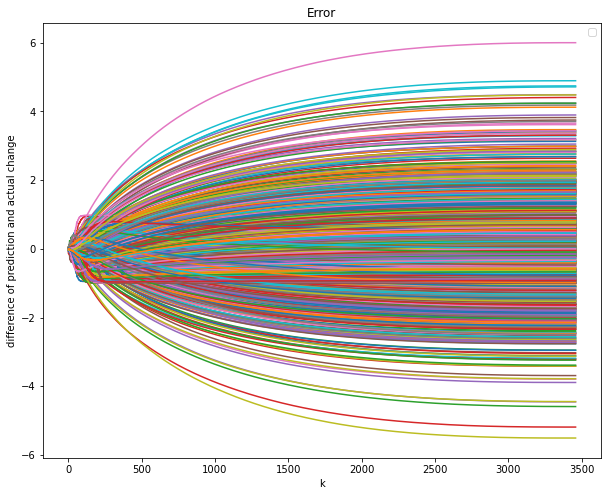

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(K, difference_k_appk.T)
plt.legend()
plt.xlabel("k")
plt.ylabel("difference of prediction and actual change")
plt.title("Error")

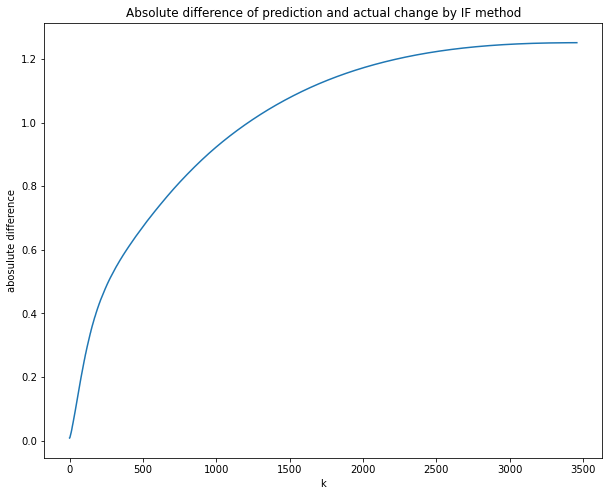

In [19]:
plt.figure(figsize=(10, 8))
mean_diff = np.mean(np.abs(difference_k_appk), axis=0)
plt.plot(K, mean_diff)
plt.xlabel("k")
plt.ylabel("u")
plt.title("Absolute difference of prediction and actual change by IF method")
plt.show()


In [160]:
np.save("mean_diff.npy", mean_diff)

# correlation k with pred

In [21]:
exact_k = np.load("exact_ks_IP.npy")[:, None]

In [22]:
exact_k.shape

(872, 1)

In [23]:
pred.shape

(872, 1)

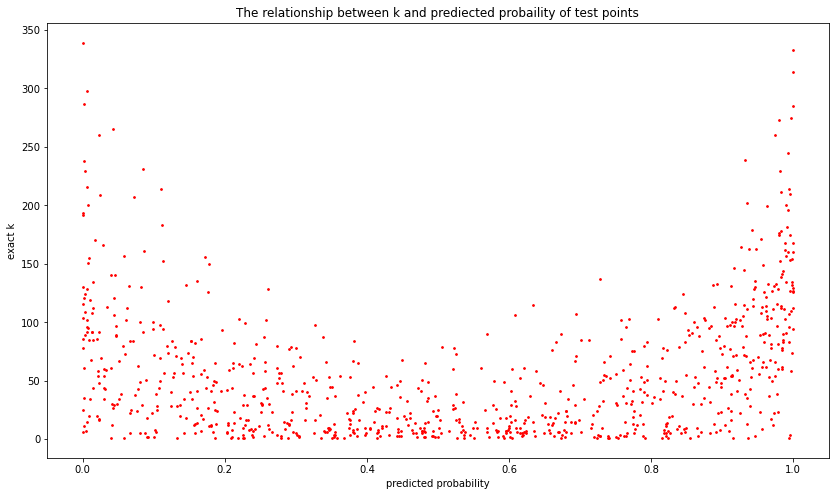

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.scatter(pred, exact_k, s=3, color='red')

plt.title("The relationship between k and prediected probaility of test points")
plt.xlabel("predicted probability")
plt.ylabel("exact k")
plt.show()

In [25]:
dis = np.array([np.abs(i - 0.5) for i in pred])

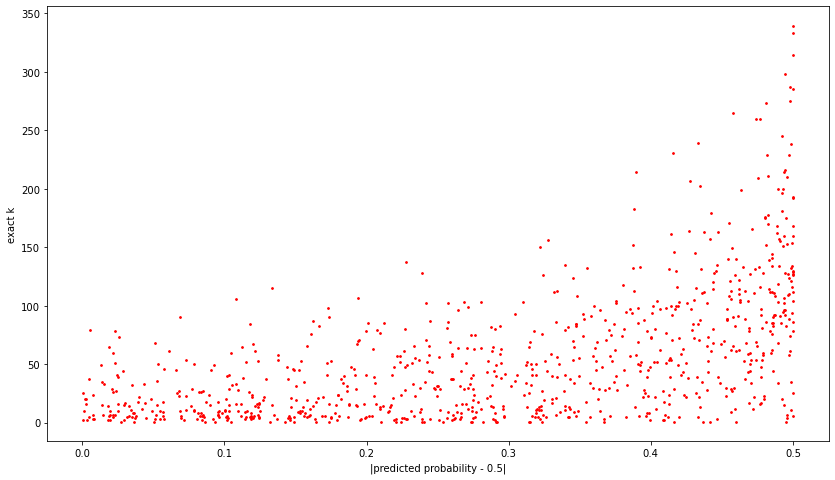

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.scatter(dis, exact_k, s=3, color='red')
 
plt.xlabel("|predicted probability - 0.5|")
plt.ylabel("exact k")
plt.show()

In [27]:
np.corrcoef(dis.squeeze(), exact_k.squeeze())

array([[1.        , 0.55972908],
       [0.55972908, 1.        ]])

In [28]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [29]:
Q = 3*a**3 - b**2

In [30]:
X = np.zeros((3, 4, 5))
np.sum(X, axis = 0).shape

(4, 5)

In [21]:
#order list
order = np.zeros((872, 6920))
for i in range(872):
    if pred[i] > 0.5:
        top_k_index = delta_pred[i].argsort()[::-1]
    else:
        top_k_index = delta_pred[i].argsort()
    order[i, :] = top_k_index

In [22]:
np.save("order_IF.npy", order)